In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [82]:
# Đọc file, lấy cột Date/Time và Close
df = pd.read_csv('/content/drive/MyDrive/Stock/FPT.csv')
df = df.drop(['Ticker','Open','High','Low','Volume','Open Interest'],axis=1)
# Bổ sung data còn thiếu bằng cách copy dữ liệu ở hàng gần nhất
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

def create_full_time_range(x):
    date = x['Date/Time'].dt.date.iloc[0]
    full_time_range = pd.date_range(start=f'{date} 09:15:00', end=f'{date} 14:46:00', freq='min')
    full_time_range = full_time_range[(full_time_range.time >= pd.to_datetime('9:15').time()) & (full_time_range.time <= pd.to_datetime('11:30').time()) | (full_time_range.time >= pd.to_datetime('13:00').time()) & (full_time_range.time <= pd.to_datetime('14:46').time())]
    return pd.DataFrame({'Date/Time': full_time_range})

full_df = df.groupby(df['Date/Time'].dt.date).apply(create_full_time_range).reset_index(drop=True)

# Kết hợp dữ liệu ban đầu với dữ liệu được tạo ra
result = pd.merge(full_df, df, on='Date/Time', how='left')
# # Điền dữ liệu cho các cột khác
result['Close'] = result['Close'].fillna(method='ffill')
# Lấy dữ liệu cột Close
data = result.iloc[:,[1]].values

# Chuẩn hóa dữ liệu 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
data= sc.fit_transform(data)

In [83]:
print(len(data))

121257


In [84]:
#Chia data theo ngày 
size=243
temp=0
day=[]
dataset=[]
for i in range(len(data)):
  day.append(data[i])
  temp+=1
  if (temp==size):
    temp=0
    dataset.append(day)
    day=[]
dataset=np.asarray(dataset)
dataset=dataset.reshape(len(dataset),size)
print(dataset.shape)

(499, 243)


In [85]:
# Chia data thành tập train và nhãn theo yêu cầu lấy dữ liệu 7 ngày để dự đoán cho 1 ngày kế tiếp
wd_size=7
h_size=1
X_dataset = []
y_dataset = []
no_of_sample = len(dataset)
for i in range(wd_size, no_of_sample):
    X_dataset.append(dataset[i-wd_size:i])
    y_dataset.append(dataset[i:i+h_size])
X_dataset, y_dataset = np.array(X_dataset), np.array(y_dataset)

X_dataset=X_dataset.reshape(no_of_sample - wd_size,size * wd_size,1)
y_dataset=y_dataset.reshape(no_of_sample - wd_size,size)
print(X_dataset.shape,y_dataset.shape)

(492, 1701, 1) (492, 243)


In [86]:
# Phân chia tập train, test
train_size = int(len(X_dataset) * 0.8)
test_size = len(X_dataset) - train_size
X_train, X_test = X_dataset[0:train_size,:], X_dataset[train_size:len(X_dataset),:]
y_train, y_test = y_dataset[0:train_size,:], y_dataset[train_size:len(y_dataset),:]
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(393, 1701, 1) (393, 243)
(99, 1701, 1) (99, 243)


In [101]:
# # Xay dung model LSTM
Myfinal = Sequential()
Myfinal.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50, return_sequences = True))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50, return_sequences = True))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50))
Myfinal.add(Dropout(0.2))
Myfinal.add(Dense(units = size))
Myfinal.compile(optimizer = 'adam', loss = 'mean_squared_error')
Myfinal.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1701, 50)          10400     
                                                                 
 dropout_36 (Dropout)        (None, 1701, 50)          0         
                                                                 
 lstm_37 (LSTM)              (None, 1701, 50)          20200     
                                                                 
 dropout_37 (Dropout)        (None, 1701, 50)          0         
                                                                 
 lstm_38 (LSTM)              (None, 1701, 50)          20200     
                                                                 
 dropout_38 (Dropout)        (None, 1701, 50)          0         
                                                                 
 lstm_39 (LSTM)              (None, 50)               

In [102]:
Myfinal.fit(X_train, y_train, epochs = 150, batch_size = 32)
Myfinal.save("Myfinal.h5")

Epoch 1/150
13/13 [==============================] - 12s 167ms/step - loss: 0.1999
Epoch 2/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0820
Epoch 3/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0230
Epoch 4/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0126
Epoch 5/150
13/13 [==============================] - 2s 185ms/step - loss: 0.0107
Epoch 6/150
13/13 [==============================] - 2s 184ms/step - loss: 0.0091
Epoch 7/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0076
Epoch 8/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0073
Epoch 9/150
13/13 [==============================] - 2s 158ms/step - loss: 0.0067
Epoch 10/150
13/13 [==============================] - 2s 156ms/step - loss: 0.0061
Epoch 11/150
13/13 [==============================] - 2s 180ms/step - loss: 0.0058
Epoch 12/150
13/13 [==============================] - 3s 202ms/step - loss: 0.0059
Epoch 13/150

In [103]:
predicted_stock_price = Myfinal.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

4/4 [==============================] - 3s 91ms/step


In [104]:
# print(predicted_stock_price)
print(predicted_stock_price.shape)

(99, 243)


In [105]:
real_stock_price=sc.inverse_transform(y_test)

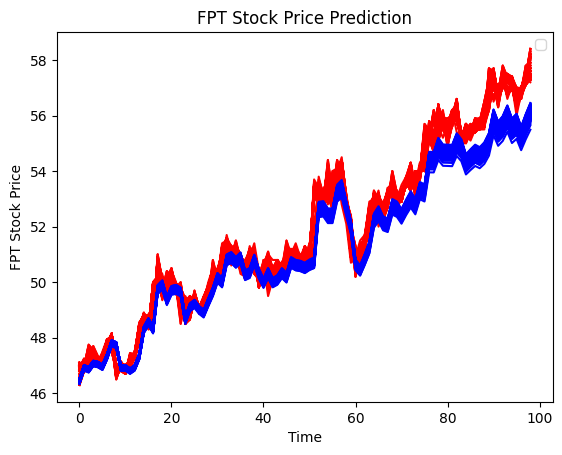

In [106]:
plt.plot(real_stock_price, color = 'red')
plt.plot(predicted_stock_price, color = 'blue')
# plt.plot(predicted_stock_price - real_stock_price)
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()

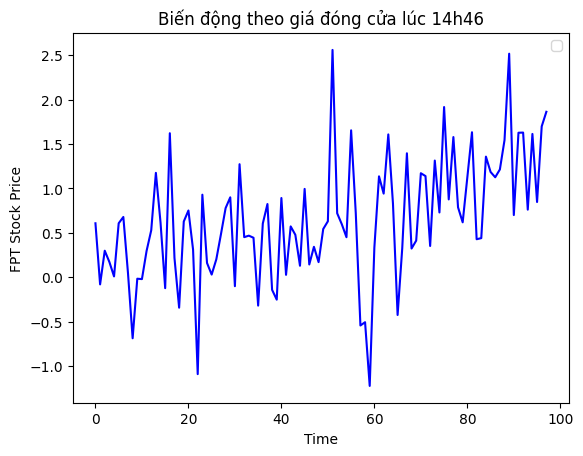

In [107]:
real=[]
predict=[]
change=[]
for i in range(0,98):
  real.append(real_stock_price[i][242])
  predict.append(predicted_stock_price[i][242])
  change.append(real_stock_price[i][242]-predicted_stock_price[i][242])
# plt.plot(real-predict, color = 'red')
plt.plot(change, color = 'blue')
plt.title('Biến động theo giá đóng cửa lúc 14h46')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()